# Pre-entrainement d'un mini GPT


## 1. Imports et configuration globale

In [1]:
from dataclasses import replace
from pathlib import Path
import time

import matplotlib.pyplot as plt
import torch

from gptlight.config import GPT2_CONFIG_124M
from gptlight.datasets import fetch_verdict_text
from gptlight.models import GPTModel
from gptlight.tokenizer import GPTTokenizer
from gptlight.training import Trainer
from gptlight.training.checkpoint import save_model
from gptlight.training.loss import llm_loss
from gptlight.utils import create_dataloader, generate_text_simple


In [2]:
torch.manual_seed(123)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Entrainement sur: {device}")


Entrainement sur: cpu


## 2. Configuration du modele
La configuration GPT-2 "124M" est reprise telle quelle, avec une longueur de contexte reduite pour rester compatible avec une machine locale.


In [3]:
cfg = replace(
    GPT2_CONFIG_124M,
    context_length=256,
    drop_rate=0.1,
)

model = GPTModel(cfg).to(device)
tokenizer = GPTTokenizer()

num_params = sum(p.numel() for p in model.parameters())
print(f"Nombre total de parametres: {num_params:,}")
print(f"Longueur de contexte: {cfg.context_length} tokens")


Nombre total de parametres: 162,419,712
Longueur de contexte: 256 tokens


## 3. Evaluer un modele non entraine
Cette etape illustre le comportement aleatoire d'un modele initialise, histoire de motiver la phase d'apprentissage.


In [52]:
torch.manual_seed(123)
prompt = "Every effort moves you"
start_ids = tokenizer.encode(prompt).to(device)

generated_ids = generate_text_simple(
    model=model,
    idx=start_ids,
    max_new_tokens=40,
    context_size=cfg.context_length,
)

generated_text = tokenizer.decode(generated_ids[0].cpu())
print(generated_text)


Every effort moves you SamoaVers Kimberly mobilized Mac IPTok courier Shard strenTemp Agric euth Package hand�it AdrianALKistentjam…) rotor Chevrolet unfolding ," chanting Hands def fren Cant relax stimulating resorts accumulated inboxawa Advanceissy Correction


Le texte genere (`Every effort moves youumper ear ... horn`) illustre bien le bruit d'un reseau non entraine et sert de point de comparaison apres la phase d'apprentissage.


La sortie ressemble a `Every effort moves youumper ear announce emptiness granddaughterervatives subjug superintendentSomething horn`, preuve que le reseau non entraine assemble des mots sans coherence.


## 4. Comprendre la cross-entropy

In [53]:
example_texts = [
    "Every effort moves you forward",
    "I really like pizza on rainy days",
]

encoded = [tokenizer.encode(text).squeeze(0) for text in example_texts]
min_tokens = min(len(ids) for ids in encoded) - 1
inputs = torch.stack([ids[:min_tokens] for ids in encoded])
targets = torch.stack([ids[1:min_tokens + 1] for ids in encoded])

with torch.inference_mode():
    logits = model(inputs.to(device)).cpu()

probas = torch.softmax(logits, dim=-1)
target_probas = torch.gather(
    probas,
    dim=2,
    index=targets.unsqueeze(-1),
).squeeze(-1)

log_target_probas = torch.log(target_probas + 1e-9)
avg_log_proba = log_target_probas.mean()
manual_loss = -avg_log_proba
auto_loss = llm_loss(logits, targets)

print(f"Log-proba moyenne des tokens cibles: {avg_log_proba:.4f}")
print(f"Perte manuelle (NLL): {manual_loss:.4f}")
print(f"llm_loss: {auto_loss:.4f}")


Log-proba moyenne des tokens cibles: -10.9142
Perte manuelle (NLL): 10.9142
llm_loss: 10.9143


## 5. Charger le corpus avec l'utilitaire

In [54]:
raw_text = fetch_verdict_text()

print(f"Nombre de caracteres: {len(raw_text):,}")
print(raw_text[:400])


KeyboardInterrupt: 

## 6. Jeu d'entrainement vs validation

In [ ]:
train_ratio = 0.90
split_idx = int(len(raw_text) * train_ratio)
train_data = raw_text[:split_idx]
val_data = raw_text[split_idx:]

print(f"Taille train (caracteres): {len(train_data):,}")
print(f"Taille val   (caracteres): {len(val_data):,}")


Taille train (caracteres): 18,431
Taille val   (caracteres): 2,048


### DataLoader pour GPT


In [ ]:
batch_size = 2
stride = cfg.context_length

train_loader = create_dataloader(
    txt=train_data,
    batch_size=batch_size,
    max_length=cfg.context_length,
    stride=stride,
    shuffle=True,
    drop_last=True,
)

val_loader = create_dataloader(
    txt=val_data,
    batch_size=batch_size,
    max_length=cfg.context_length,
    stride=stride,
    shuffle=False,
    drop_last=False,
)

example_inputs, example_targets = next(iter(train_loader))
print(f"Input batch shape: {example_inputs.shape}")
print(f"Target batch shape: {example_targets.shape}")
print(f"Nombre de batches train: {len(train_loader)}")
print(f"Nombre de batches val:   {len(val_loader)}")


Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Nombre de batches train: 9
Nombre de batches val:   1


## 7. Lancer l'entrainement
La classe `Trainer` standardise la boucle epochs, le clipping de gradient et la journalisation des pertes.


In [ ]:
num_epochs = 10
learning_rate = 3e-4
grad_clip = 1.0
eval_every = 1

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=0.1,
)

trainer = Trainer(
    model=model,
    optimizer=optimizer,
    device=device,
    grad_clip=grad_clip,
)

start_time = time.perf_counter()
history = trainer.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    eval_every=eval_every,
    verbose=True,
)
training_time = time.perf_counter() - start_time
print(f"Temps total: {training_time:.1f} s")


[Epoch 1/10] train_loss=9.2938 | val_loss=8.0347
[Epoch 2/10] train_loss=6.9251 | val_loss=6.6275
[Epoch 3/10] train_loss=5.8393 | val_loss=6.3704
[Epoch 4/10] train_loss=5.0066 | val_loss=6.1969
[Epoch 5/10] train_loss=4.0730 | val_loss=6.2276
[Epoch 6/10] train_loss=3.2036 | val_loss=6.1904
[Epoch 7/10] train_loss=2.3667 | val_loss=6.2806
[Epoch 8/10] train_loss=1.6497 | val_loss=6.4501
[Epoch 9/10] train_loss=1.0696 | val_loss=6.4008
[Epoch 10/10] train_loss=0.6565 | val_loss=6.5859
Temps total: 754.3 s


> Sauvegarder le modele pre-entraine


In [ ]:
checkpoint_dir = Path("checkpoints")
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "pretraining-demo.pt"

save_model(
    model=trainer.model,
    path=str(checkpoint_path),
    #optimizer=trainer.optimizer,
    #epoch=len(history["train_loss"]),
)

print(f"Checkpoint enregistre dans {checkpoint_path}")


## 8. Visualiser la courbe d'apprentissage

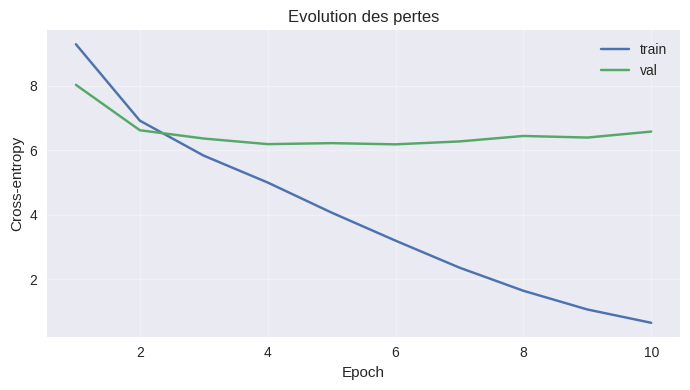

In [ ]:
def plot_learning_curve(history):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.style.use("seaborn-v0_8")
    plt.figure(figsize=(7, 4))
    plt.plot(epochs, history["train_loss"], label="train")
    if "val_loss" in history:
        plt.plot(epochs, history["val_loss"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Cross-entropy")
    plt.title("Evolution des pertes")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_learning_curve(history)


Comme on peut le constater, les pertes d'apprentissage et de validation diminuent pendant la premiere epoch puis divergent apres la seconde. Cette divergence, combinee au fait que la perte de validation devient beaucoup plus elevee que la perte d'apprentissage, indique que le modele sur-apprend les donnees d'entree. Il suffit de rechercher les extraits generes (par exemple "quite insensible to the irony") dans le fichier *The Verdict* pour verifier que le modele memorise mot pour mot son jeu d'entree.

Cette memorisation est attendue ici, car le jeu de donnees est minuscule et le reseau est entraine sur plusieurs epochs. En pratique, on prefere souvent n'effectuer qu'une seule epoch sur un corpus bien plus volumineux.


## Strategies de decodage pour controler l'aleatoire


Nous reappliquons d'abord `generate_text_simple`, puis nous presentons deux techniques pour enrichir cette fonction : l'ajustement de temperature et l'echantillonnage top-k.


In [ ]:
torch.manual_seed(42)
prompt = "That was his history."
start_ids = tokenizer.encode(prompt).to(device)
pre_trained_model = trainer.model

generated_ids = generate_text_simple(
    model=pre_trained_model,
    idx=start_ids,
    max_new_tokens=60,
    context_size=cfg.context_length,
)

print(tokenizer.decode(generated_ids[0].cpu()))


That was his history. It was not that my hostess was "interesting": on that point I could have given Miss Croft the fullest reassurance. It was just because she was _not_ interesting--if I saw that, when Stroud laid in the first stroke, he knew just what the end would be.


Comme explique precedemment, le token genere a chaque etape correspond au score de probabilite maximal parmi tout le vocabulaire. Le LLM renverra donc exactement les memes sorties si l'on relance `generate_text_simple` avec le meme prompt initial.


### Reglage de la temperature


Le reglage de temperature introduit un processus probabiliste dans la generation du prochain token. Jusqu'ici, `generate_text_simple` choisissait toujours le token le plus probable via `torch.argmax` (decodage avide). Pour diversifier les textes, on peut remplacer `argmax` par une fonction qui echantillonne a partir d'une distribution de probabilite (ici, les probabilites que le LLM associe a chaque token du vocabulaire a chaque pas de generation).


Pour illustrer l'echantillonnage probabiliste sur un exemple concret, examinons un processus de generation avec un vocabulaire jouet.


In [ ]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

Supposons ensuite que le LLM recoive le contexte initial "every effort moves you" et produise les logits suivants pour le prochain token :


In [ ]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

Dans `generate_text_simple`, nous convertissons les logits en probabilites via softmax puis recuperons l'identifiant du token associe au maximum avant de le decoder en texte via le vocabulaire inverse :


In [ ]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


Comme le plus grand logit (et donc la probabilite softmax la plus elevee) se situe a la quatrieme position (index 3 en Python), le mot genere est "forward".

Pour rendre le choix probabiliste, il suffit de remplacer `argmax` par la fonction `multinomial` de PyTorch :


In [ ]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


La sortie affiche encore "forward". Pourquoi ? `multinomial` echantillonne le prochain token proportionnellement a sa probabilite. "forward" reste donc le mot le plus probable et sera choisi la plupart du temps, mais pas systematiquement. Pour le montrer, implementons une fonction qui repete cet echantillonnage 1 000 fois :


In [ ]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [
        torch.multinomial(probas, num_samples=1).item() for i in range(1_000)
    ]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


On observe que "forward" est selectionne dans 544 essais sur 1 000, mais d'autres tokens comme "closer", "inches" ou "toward" apparaissent aussi.

Autrement dit, si l'on remplace `argmax` par `multinomial` dans `generate_text_simple`, le LLM produira parfois des phrases telles que "every effort moves you toward", "... inches" ou "... closer" au lieu de "... forward".


On peut encore ajuster la distribution et le processus de selection a l'aide d'un facteur de temperature, qui equivaut a diviser les logits par un nombre strictement positif :


In [ ]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

Des temperatures superieures a 1 rendent les probabilites des tokens plus uniformes, tandis que des temperatures inferieures a 1 les rendent plus piquees (plus confiantes). Illustrons cela en tracant les probabilites originales a cote de celles mises a l'echelle avec plusieurs temperatures :


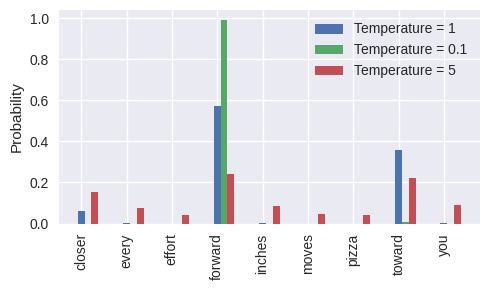

In [ ]:
temperatures = [1, 0.1, 5]
scaled_probas = [
    softmax_with_temperature(next_token_logits, T) for T in temperatures
]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(
        x + i * bar_width, scaled_probas[i],bar_width, label=f'Temperature = {T}'
    )
    
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

Comme le montre la figure, appliquer une temperature tres faible (par exemple 0.1) produit une distribution tres piquee : `multinomial` choisit alors presque toujours le token le plus probable (ici "forward"), ce qui rapproche son comportement de `argmax`. A l'inverse, une temperature de 5 rend la distribution plus uniforme, donc d'autres tokens sont selectionnes plus souvent. Cela ajoute de la variete mais augmente aussi la probabilite d'obtenir du texte incoherent ; par exemple, une temperature de 5 genere "every effort moves you pizza" environ 4 % du temps.


### Echantillonnage top-k


Nous disposons maintenant d'un echantillonnage probabiliste module par la temperature pour diversifier les sorties. Des temperatures elevees rendent les probabilites du prochain token plus uniformes, ce qui limite la repetition systematique du mot le plus probable et explore des continuations plus creatrices. L'inconvenient est que l'on obtient parfois des phrases grammaticalement fautives ou absurdes, telles que "every effort moves you pizza".


L'echantillonnage top-k, combine a l'echantillonnage probabiliste et a la temperature, ameliore la generation. Il consiste a restreindre le tirage aux k tokens les plus probables et a masquer les autres en mettant leur probabilite a zero.

Concretement, on remplace les logits non selectionnes par `-inf`. Lorsqu'on applique softmax, les tokens exclus obtiennent ainsi une probabilite nulle et la somme des probabilites des k meilleurs tokens reste egale a 1.


In [ ]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(-torch.inf),
    other=next_token_logits
)
print(new_logits)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])
tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


Il ne reste plus qu'a appliquer softmax pour convertir ces logits tronques en probabilites de prochain token :


In [ ]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


Nous pouvons alors combiner temperature et `multinomial` pour echantillonner le prochain token parmi ces trois probabilites non nulles. La derniere etape consiste a mettre a jour la fonction de generation.


### Modifier la fonction de generation


Nous fusionnons desormais le reglage de temperature et le top-k dans une nouvelle variante de `generate_text_simple` pour produire des textes plus varies.


> Fonction de generation modifiee pour plus de diversite


In [ ]:
def generate(
    model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None
    ):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        
        if temperature >0.0:
            if top_k is not None:
                top_logits, _ = torch.topk(logits, top_k)
                min_val = top_logits[:, -1]
                logits = torch.where(
                    condition=logits<min_val,
                    input=torch.tensor(-torch.inf).to(logits.device),
                    other=logits
                )
            logits = logits/temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)

        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        if idx_next == eos_id:
            break
        
        idx = torch.cat((idx, idx_next), dim=-1)
        
    return idx

Observons maintenant le comportement de cette nouvelle fonction de generation en pratique :


In [ ]:
torch.manual_seed(123)
token_ids = generate(
    model=trainer.model,
    idx=tokenizer.encode("Every effort moves you"),
    max_new_tokens=12,
    context_size=GPT2_CONFIG_124M.context_length,
    top_k=25,
    temperature=1.4
)
print("Output text:\n", tokenizer.decode(token_ids))

Output text:
 Every effort moves you know Jack Gis for a a little it was such

